# Gaussian Mixture Model EM
### Dano Gillam

### Our Variables
* **data**`: a list of data points. of dimension 'dimension'
* **N** : the number of data points
* **dimension**   : dimensionality of problem  
* **groupcount**   : number of groups
    * **k** : index of groupcount
* **mus** : $\mu$ : $list(dimension \times groupcount)$ : our means. each mean is a d-length vector  
    * `mus[:,k]` : the mean for the $k^{th}$ gaussian 
* **mws** : $\pi$ : $list(groupcount)$

### import statements

In [1]:
from __future__ import division
import numpy as np
import scipy.io
from matplotlib  import pyplot as plt
import matplotlib
from scipy.stats import multivariate_normal as normal
import seaborn
%matplotlib inline


### plotting function

In [2]:
#plots an ellipse
def cov_to_pts( cov ):
    circ = np.linspace( 0, 2*np.pi, 100 )
    sf = np.asarray( [ np.cos( circ ), np.sin( circ ) ] )
    [u,s,v] = np.linalg.svd( cov )
    pmat = u*2.447*np.sqrt(s) # 95% confidence
    return np.dot(  pmat, sf )

#Plots datapoints along with two ellipses representing the 95% confidence interval of a gaussian.
def myplot(data,mws, mus, covs,R,title=''):
    cov1,cov2 = covs
    ellipse1X = cov_to_pts(cov1)[0]+mus[0,0]
    ellipse1Y = cov_to_pts(cov1)[1]+mus[1,0]
    ellipse2X = cov_to_pts(cov2)[0]+mus[0,1]
    ellipse2Y = cov_to_pts(cov2)[1]+mus[1,1]
    
    plt.scatter(data[:,0],data[:,1],color=map(str,R[:,1]),edgecolors='black')
    plt.plot(ellipse1X,ellipse1Y,'b',label='Class 1')#blue ellipse
    plt.plot(ellipse2X,ellipse2Y,'g',label='Class 2')#green ellipse
    plt.scatter(mus[0,0],mus[1,0],c='b',marker='*',s=200,label='Class 1 mean')
    plt.scatter(mus[0,1],mus[1,1],c='g',marker='*',s=200,label='Class 2 mean')
    
    plt.ylim(-40,30)
    plt.xlim(-3,3)
    plt.title(title)
    plt.legend(loc = 'lower right')
    
    plt.show()




### EM Algorithm

#### The E step
* Update responsibilities $r_{ik}$:  
$r_{ik} = \frac{\pi_kp(\pmb x_i|\theta_k^{(t-1)})}{\sum_{k'}\pi_{k'}p(\pmb x_i|\theta_{k'}^{(t-1)})}$  
This is performed by `find_r()`  
* Update mixing weights $\pi_k$:  
    * $r_k = \sum_ir_{ik}$
    * $\pi_k=\frac{r_k}{N}$  
* Update covariances $\Sigma_k$
    

In [3]:
def find_r(data,mws,mus,covs,groupcount):
    def r(i, k): #return probability of Y=k given X[i] and theta
        denom = sum([(mws[c])*normal.pdf(data[i], mus[:, c], np.atleast_2d(covs[c])) for c in xrange(groupcount)])
        return (mws[k]) * normal.pdf(data[i], mus[:, k], np.atleast_2d(covs[k])) / denom  #return probability of X given Y=j
    R = np.zeros((N,groupcount))
    for row in xrange(N):
        for col in xrange(groupcount):
            R[row,col]= r(row,col)
    return R

def EM_GMM(data, mws, mus, covs):
    N=len(data) 
    groupcount = len(mws)
    
    new_mws  = [0]*(len(mws))
    new_mus  = np.zeros(mus.shape)
    new_covs = [0]* len(covs)   
        
    #this is the E-step 
    R = find_r(data,mws,mus,covs,groupcount)
    
    #this is the M-step
    for k in xrange(groupcount):
        
        rk = sum([R[i, k] for i in xrange(N)])
        #new mws 
        new_mws[k] = rk / N
        #new covs
        new_covs[k] = sum([R[i, k]*np.dot( np.atleast_2d(data[i]-mus[:,k]).T ,np.atleast_2d(data[i]-mus[:,k]) ) for i in xrange(N)]) / rk 
        #new mus
        new_mus[:, k] = sum([R[i, k]* data[i] for i in xrange(N)]) / rk

    return new_mws, new_mus, new_covs,R

### Initial guess

In [4]:
'''----------set initial guess----------'''
# the Gaussian means (as column vectors -- ie, the mean for Gaussian 0 is mus[:,0]
mus0 = np.asarray( [[-1.17288986, -0.11642103],
                   [-0.16526981,  0.70142713]])
 
# the Gaussian covariance matrices. covs[0] is the covariance matrix for Gaussian 0
covs0 = list()
covs0.append( 
    np.asarray([[ 0.74072815,  0.09252716],
                [ 0.09252716,  0.5966275 ]]) )
covs0.append( 
    np.asarray([[ 0.39312776, -0.46488887],
                [-0.46488887,  1.64990767]]) )

# The Gaussian mixing weights
mws0 = [ 0.68618439, 0.31381561 ]  # (Mixing WeightS) called alpha in the slides



### Run EM on our dataset

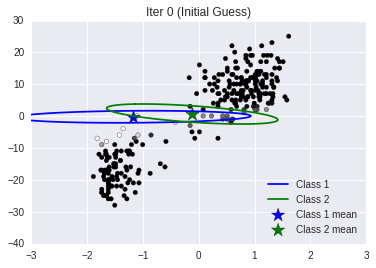

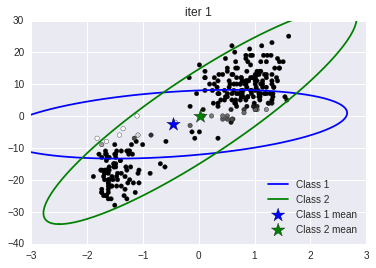

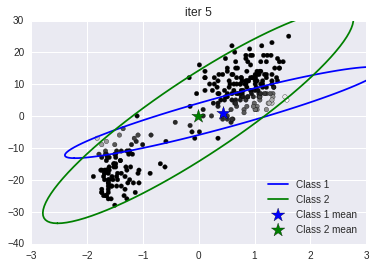

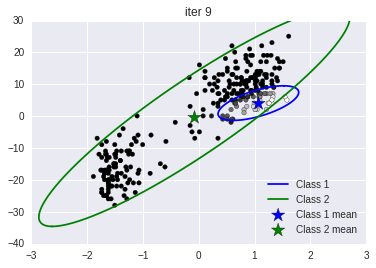

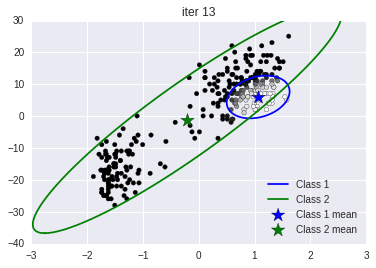

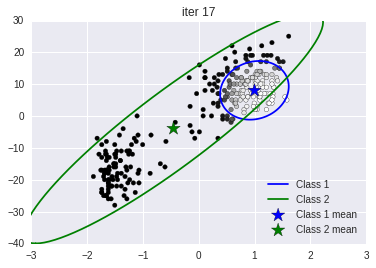

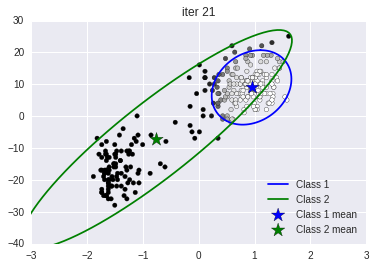

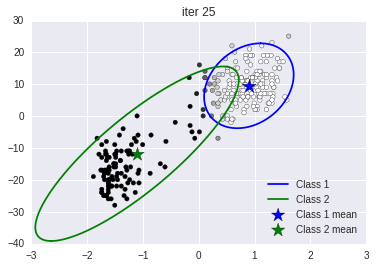

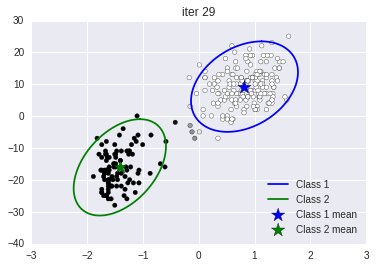

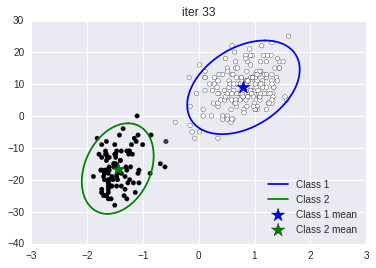

In [5]:
# get data
data = scipy.io.loadmat('old_faithful.mat')['data']
#mean center the data
data = data-np.mean(data,axis=0)
N=len(data)

#initial guess
R0 = find_r(data,mws0,mus0,covs0,2)
myplot(data,mws0,mus0,covs0,R0,'Iter 0 (Initial Guess)')

#first iteration
mwsi,musi,covsi,Ri = EM_GMM(data, mws0, mus0, covs0)
myplot(data,mwsi, musi, covsi,Ri,title='iter 1')

#more iterations
for i in xrange(33):
    mwsi,musi,covsi,Ri = EM_GMM(data, mwsi, musi, covsi)
    if i in range(3,32,4):
        myplot(data,mwsi, musi, covsi,Ri,'iter '+str(i+2))
        
